 ##  0. Importing Packages

In [12]:
%run import_modules.py

import warnings
import time
import pandas as pd
import numpy as np
import os
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


import matplotlib.pylab as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#tf.logging.set_verbosity(tf.logging.ERROR)
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#from tensorflow import set_random_seed         ##tf.random.set_seed(1)
import keras 
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping

from scipy.stats.mstats import gmean

In [13]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data


## 1. Reading Data

In [3]:
myseed = 56
to_remove = ['휴면(이탈)여부','화장품품목구매여부', '디자이너품목구매여부', '시티웨어품목구매여부', #Target Features to remove
             '구매상품종류1_cat', '내점일수_cat', '총구매액_cat','최대구매액_cat','내점당구매액_cat','행사상품구매총액_cat']

raw_feature = pd.read_csv('Raw_feature_continuos+categorical_before_Encoding.csv',encoding='cp949', index_col=0) #F2
raw_feature_label = pd.read_csv('Raw_feature_labelencoding+categorical_before_Encoding.csv',encoding='cp949', index_col=0) #F1
raw_feature_label_c = pd.read_csv('Raw_feature_labelencoding+categorical_before_Encoding_cleansed.csv',encoding='cp949', index_col=0) #F1_Cleansed

y_train = pd.read_csv('y_train.csv').gender # y_train
IDtest = pd.read_csv('X_test.csv', encoding='cp949').cust_id.unique() #target ID for prediction

# Train, Test (F1)
train = raw_feature_label[:3500]
test = raw_feature_label[3500:]

#Feature Segregation
cat_features = list(raw_feature_label.select_dtypes(include=['object']).columns)
num_features = [c for c in raw_feature_label.columns.tolist() if c not in cat_features]

## 2. Data Preprocessing  

- Mean Encoding

In [4]:
train['gender'] = y_train #append gender column to train set

def calc_me_cv(df, by, on, cv):
    mean = df[on].mean()
    df_new = df.copy() 
    df_new[:] = np.nan 
    df_new[by+'_encoded'] = np.nan

    X_df = df.drop(on, axis=1) 
    Y_df = df[on]
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=myseed)
    for tr_idx, val_idx in skf.split(X_df, Y_df):
        X_df, X_val = df.iloc[tr_idx], df.iloc[val_idx]
        # train set 에서 구한 mean encoded 값을 validation set 에 매핑해줌. 
        X_val[by+'_encoded'] = X_val[by].map(X_df.groupby(by)[on].mean()) 
        df_new.iloc[val_idx] = X_val
    
    df_new[by+'_encoded'] = df_new[by+'_encoded'].fillna(mean)
    
    return df_new[by+'_encoded']

for col in cat_features:
    train[col+'_encoded']=calc_me_cv(train,col,'gender',10)

dict_sexmean = []
for col in cat_features:
    df = pd.concat([train[col],train[col+'_encoded']],axis=1).groupby(col)[col+'_encoded'].agg(np.mean).to_dict()
    dict_sexmean.append(df)


#test data 인코딩
cat_keycols = train[cat_features].columns
cat_valcols = train.iloc[:,-6:].columns

for i in range(len(cat_keycols)):
    test[cat_valcols[i]] = test[cat_keycols[i]].map(dict_sexmean[i]).fillna(np.mean(train.gender))

train = train.drop(columns=cat_features).drop(columns='gender')
test = test.drop(columns=cat_features)
train_test = pd.concat([train,test])

# Bool Type feature -> convert to float type
bool_features = train_test.select_dtypes(include=['bool'])
for col in bool_features:
    train_test[col] = train_test[col].astype(float)

   * Removing Outliers

In [5]:
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

* Convert to Log

In [6]:
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

* MinMax Scaling

In [7]:
train_test = train_test.set_index('cust_id')
X_train = train_test[:3500]
X_test = train_test[3500:]

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

train_test = pd.concat([X_train, X_test], ignore_index=True)

## 3. Feature Engineering

In [8]:
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], 
                          n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        onehot = self.cluster_encoder.transform(clusters.reshape(-1,1)).toarray()
        max_col = onehot.shape[1]
        pca = PCA(n_components=max_col, random_state=0).fit(onehot)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        num_col = np.argmax(cumsum >= 0.99) + 1
        if num_col == 1: num_col = max_col
        pca = PCA(n_components = num_col, random_state=0).fit_transform(onehot)
        return pd.DataFrame(pca)
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [9]:
# Perform k-means clustering
kmf_hint = KMeansFeaturizer(k=9, target_scale=5, random_state=myseed).fit(X_train, y_train) # Select best k,target_scale 

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(X_train)
test_cluster_features = kmf_hint.transform(X_test)

# Augment existing features with the k-means clustering features
X_train = pd.concat([X_train, training_cluster_features], axis=1)
X_test = pd.concat([X_test, test_cluster_features], axis=1)
X_train.columns = range(1, X_train.shape[1]+1)
X_test.columns = range(1, X_test.shape[1]+1)

print(X_train.shape,X_test.shape)

(3500, 62) (2482, 62)


## 3. Build Models

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 32)           2016        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 32)           0           dense_11[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 32)           1056        dropout_5[0][0]                  
____________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 35us/step - loss: 0.5546 - acc: 0.7271 - auc_2: 0.7665 - val_loss: 0.5488 - val_acc: 0.7286 - val_auc_2: 0.7666
Epoch 34/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5580 - acc: 0.7231 - auc_2: 0.7668 - val_loss: 0.5507 - val_acc: 0.7200 - val_auc_2: 0.7669
Epoch 35/100
3500/3500 [==============================] - 0s 29us/step - loss: 0.5529 - acc: 0.7280 - auc_2: 0.7671 - val_loss: 0.5606 - val_acc: 0.7271 - val_auc_2: 0.7672
Epoch 36/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5548 - acc: 0.7289 - auc_2: 0.7673 - val_loss: 0.5496 - val_acc: 0.7357 - val_auc_2: 0.7674
Epoch 37/100
3500/3500 [==============================] - 0s 35us/step - loss: 0.5528 - acc: 0.7314 - auc_2: 0.7676 - val_loss: 0.5483 - val_acc: 0.7314 - val_auc_2: 0.7677
Epoch 38/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5529 - acc: 0.7263 - auc_2: 0.7679 - val_loss: 0.5488 

3500/3500 [==============================] - 0s 29us/step - loss: 0.5477 - acc: 0.7317 - auc_2: 0.7753 - val_loss: 0.5396 - val_acc: 0.7357 - val_auc_2: 0.7753
Epoch 81/100
3500/3500 [==============================] - 0s 28us/step - loss: 0.5426 - acc: 0.7306 - auc_2: 0.7754 - val_loss: 0.5400 - val_acc: 0.7314 - val_auc_2: 0.7755
Epoch 82/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5477 - acc: 0.7260 - auc_2: 0.7755 - val_loss: 0.5403 - val_acc: 0.7329 - val_auc_2: 0.7756
Epoch 83/100
3500/3500 [==============================] - 0s 34us/step - loss: 0.5424 - acc: 0.7291 - auc_2: 0.7756 - val_loss: 0.5346 - val_acc: 0.7329 - val_auc_2: 0.7757
Epoch 84/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5405 - acc: 0.7340 - auc_2: 0.7758 - val_loss: 0.5437 - val_acc: 0.7300 - val_auc_2: 0.7758
Epoch 85/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5502 - acc: 0.7309 - auc_2: 0.7759 - val_loss: 0.5386 - val_acc: 0.

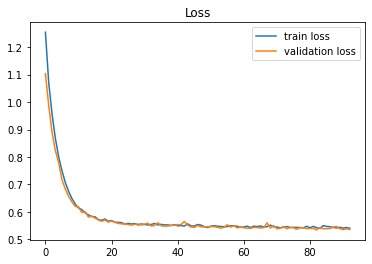

 10%|████████▎                                                                          | 1/10 [00:15<02:15, 15.07s/it]

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 32)           2016        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 32)           0           dense_16[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 32)           1056        dropout_7[0][0]                  
____________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5556 - acc: 0.7351 - auc_3: 0.7693 - val_loss: 0.5407 - val_acc: 0.7414 - val_auc_3: 0.7695
Epoch 34/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5530 - acc: 0.7286 - auc_3: 0.7697 - val_loss: 0.5378 - val_acc: 0.7429 - val_auc_3: 0.7698
Epoch 35/100
3500/3500 [==============================] - 0s 28us/step - loss: 0.5584 - acc: 0.7280 - auc_3: 0.7700 - val_loss: 0.5381 - val_acc: 0.7414 - val_auc_3: 0.7701
Epoch 36/100
3500/3500 [==============================] - 0s 29us/step - loss: 0.5509 - acc: 0.7334 - auc_3: 0.7704 - val_loss: 0.5456 - val_acc: 0.7371 - val_auc_3: 0.7704
Epoch 37/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5516 - acc: 0.7300 - auc_3: 0.7707 - val_loss: 0.5401 - val_acc: 0.7386 - val_auc_3: 0.7708
Epoch 38/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5536 - acc: 0.7314 - auc_3: 0.7710 - val_loss: 0.5459 

3500/3500 [==============================] - 0s 32us/step - loss: 0.5474 - acc: 0.7263 - auc_3: 0.7768 - val_loss: 0.5325 - val_acc: 0.7414 - val_auc_3: 0.7768
Epoch 81/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5436 - acc: 0.7326 - auc_3: 0.7769 - val_loss: 0.5359 - val_acc: 0.7329 - val_auc_3: 0.7769
Epoch 82/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5481 - acc: 0.7274 - auc_3: 0.7770 - val_loss: 0.5405 - val_acc: 0.7386 - val_auc_3: 0.7770
Epoch 83/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5461 - acc: 0.7329 - auc_3: 0.7771 - val_loss: 0.5362 - val_acc: 0.7400 - val_auc_3: 0.7771
Epoch 84/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5488 - acc: 0.7326 - auc_3: 0.7772 - val_loss: 0.5578 - val_acc: 0.7214 - val_auc_3: 0.7771
Epoch 85/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5481 - acc: 0.7323 - auc_3: 0.7771 - val_loss: 0.5305 - val_acc: 0.

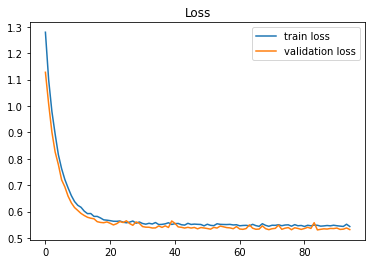

 20%|████████████████▌                                                                  | 2/10 [00:30<02:00, 15.08s/it]

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 32)           2016        input_5[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 32)           0           dense_21[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 32)           1056        dropout_9[0][0]                  
____________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5603 - acc: 0.7226 - auc_4: 0.7673 - val_loss: 0.5242 - val_acc: 0.7443 - val_auc_4: 0.7675
Epoch 34/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5565 - acc: 0.7191 - auc_4: 0.7679 - val_loss: 0.5282 - val_acc: 0.7471 - val_auc_4: 0.7678
Epoch 35/100
3500/3500 [==============================] - 0s 28us/step - loss: 0.5541 - acc: 0.7340 - auc_4: 0.7681 - val_loss: 0.5263 - val_acc: 0.7357 - val_auc_4: 0.7682
Epoch 36/100
3500/3500 [==============================] - 0s 27us/step - loss: 0.5590 - acc: 0.7226 - auc_4: 0.7684 - val_loss: 0.5227 - val_acc: 0.7357 - val_auc_4: 0.7685
Epoch 37/100
3500/3500 [==============================] - 0s 34us/step - loss: 0.5542 - acc: 0.7349 - auc_4: 0.7687 - val_loss: 0.5304 - val_acc: 0.7314 - val_auc_4: 0.7688
Epoch 38/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5532 - acc: 0.7289 - auc_4: 0.7689 - val_loss: 0.5198 

3500/3500 [==============================] - 0s 29us/step - loss: 0.5493 - acc: 0.7291 - auc_4: 0.7769 - val_loss: 0.5157 - val_acc: 0.7457 - val_auc_4: 0.7770
Epoch 81/100
3500/3500 [==============================] - 0s 28us/step - loss: 0.5473 - acc: 0.7314 - auc_4: 0.7770 - val_loss: 0.5258 - val_acc: 0.7386 - val_auc_4: 0.7771
Epoch 82/100
3500/3500 [==============================] - 0s 29us/step - loss: 0.5455 - acc: 0.7291 - auc_4: 0.7771 - val_loss: 0.5175 - val_acc: 0.7386 - val_auc_4: 0.7772
Epoch 83/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5420 - acc: 0.7349 - auc_4: 0.7773 - val_loss: 0.5189 - val_acc: 0.7500 - val_auc_4: 0.7773
Epoch 84/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5442 - acc: 0.7317 - auc_4: 0.7774 - val_loss: 0.5118 - val_acc: 0.7386 - val_auc_4: 0.7775
Epoch 85/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5468 - acc: 0.7300 - auc_4: 0.7775 - val_loss: 0.5146 - val_acc: 0.

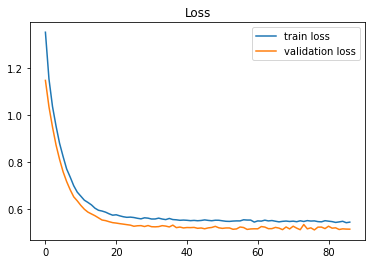

 30%|████████████████████████▉                                                          | 3/10 [00:43<01:42, 14.69s/it]

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 32)           2016        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 32)           0           dense_26[0][0]                   
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 32)           1056        dropout_11[0][0]                 
____________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5558 - acc: 0.7280 - auc_5: 0.7658 - val_loss: 0.5633 - val_acc: 0.7014 - val_auc_5: 0.7660
Epoch 34/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5550 - acc: 0.7263 - auc_5: 0.7660 - val_loss: 0.5588 - val_acc: 0.7129 - val_auc_5: 0.7662
Epoch 35/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5558 - acc: 0.7243 - auc_5: 0.7663 - val_loss: 0.5529 - val_acc: 0.7200 - val_auc_5: 0.7665
Epoch 36/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5514 - acc: 0.7280 - auc_5: 0.7666 - val_loss: 0.5517 - val_acc: 0.7186 - val_auc_5: 0.7669
Epoch 37/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5535 - acc: 0.7289 - auc_5: 0.7672 - val_loss: 0.5501 - val_acc: 0.7214 - val_auc_5: 0.7671
Epoch 38/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5507 - acc: 0.7297 - auc_5: 0.7674 - val_loss: 0.5701 

3500/3500 [==============================] - 0s 32us/step - loss: 0.5438 - acc: 0.7334 - auc_5: 0.7741 - val_loss: 0.5388 - val_acc: 0.7214 - val_auc_5: 0.7742
Epoch 81/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5451 - acc: 0.7306 - auc_5: 0.7743 - val_loss: 0.5652 - val_acc: 0.7114 - val_auc_5: 0.7743
Epoch 82/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5492 - acc: 0.7269 - auc_5: 0.7743 - val_loss: 0.5469 - val_acc: 0.7271 - val_auc_5: 0.7743
Epoch 83/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5407 - acc: 0.7331 - auc_5: 0.7744 - val_loss: 0.5425 - val_acc: 0.7329 - val_auc_5: 0.7745
Epoch 84/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5460 - acc: 0.7291 - auc_5: 0.7746 - val_loss: 0.5407 - val_acc: 0.7257 - val_auc_5: 0.7746
Epoch 85/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5502 - acc: 0.7326 - auc_5: 0.7746 - val_loss: 0.5429 - val_acc: 0.

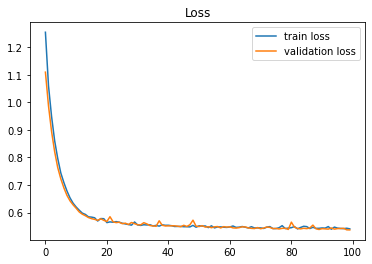

 40%|█████████████████████████████████▏                                                 | 4/10 [00:59<01:30, 15.05s/it]

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 32)           2016        input_7[0][0]                    
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 32)           0           dense_31[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 32)           1056        dropout_13[0][0]                 
____________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5521 - acc: 0.7380 - auc_6: 0.7638 - val_loss: 0.5268 - val_acc: 0.7629 - val_auc_6: 0.7641
Epoch 34/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5552 - acc: 0.7320 - auc_6: 0.7644 - val_loss: 0.5284 - val_acc: 0.7629 - val_auc_6: 0.7646
Epoch 35/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5536 - acc: 0.7291 - auc_6: 0.7649 - val_loss: 0.5341 - val_acc: 0.7514 - val_auc_6: 0.7650
Epoch 36/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5534 - acc: 0.7300 - auc_6: 0.7651 - val_loss: 0.5240 - val_acc: 0.7686 - val_auc_6: 0.7654
Epoch 37/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5494 - acc: 0.7314 - auc_6: 0.7657 - val_loss: 0.5250 - val_acc: 0.7629 - val_auc_6: 0.7660
Epoch 38/100
3500/3500 [==============================] - 0s 28us/step - loss: 0.5515 - acc: 0.7294 - auc_6: 0.7663 - val_loss: 0.5398 

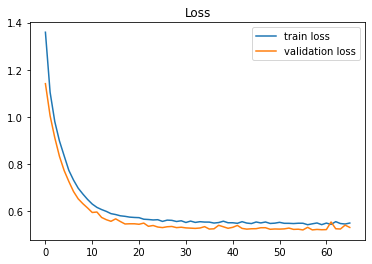

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:10<01:08, 13.76s/it]

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 32)           2016        input_8[0][0]                    
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 32)           0           dense_36[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 32)           1056        dropout_15[0][0]                 
____________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5576 - acc: 0.7263 - auc_7: 0.7693 - val_loss: 0.5261 - val_acc: 0.7486 - val_auc_7: 0.7694
Epoch 34/100
3500/3500 [==============================] - 0s 36us/step - loss: 0.5537 - acc: 0.7314 - auc_7: 0.7695 - val_loss: 0.5307 - val_acc: 0.7429 - val_auc_7: 0.7698
Epoch 35/100
3500/3500 [==============================] - 0s 36us/step - loss: 0.5498 - acc: 0.7320 - auc_7: 0.7700 - val_loss: 0.5252 - val_acc: 0.7500 - val_auc_7: 0.7702
Epoch 36/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5580 - acc: 0.7251 - auc_7: 0.7703 - val_loss: 0.5347 - val_acc: 0.7557 - val_auc_7: 0.7704
Epoch 37/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5555 - acc: 0.7294 - auc_7: 0.7705 - val_loss: 0.5249 - val_acc: 0.7471 - val_auc_7: 0.7706
Epoch 38/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5528 - acc: 0.7300 - auc_7: 0.7708 - val_loss: 0.5221 

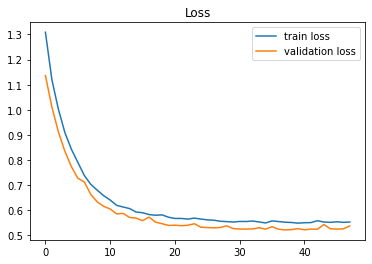

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:19<00:49, 12.31s/it]

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 32)           2016        input_9[0][0]                    
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 32)           0           dense_41[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 32)           1056        dropout_17[0][0]                 
____________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 36us/step - loss: 0.5555 - acc: 0.7280 - auc_8: 0.7605 - val_loss: 0.5582 - val_acc: 0.6986 - val_auc_8: 0.7607
Epoch 34/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5562 - acc: 0.7254 - auc_8: 0.7609 - val_loss: 0.5527 - val_acc: 0.7171 - val_auc_8: 0.7610
Epoch 35/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5515 - acc: 0.7283 - auc_8: 0.7613 - val_loss: 0.5596 - val_acc: 0.7200 - val_auc_8: 0.7615
Epoch 36/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5574 - acc: 0.7297 - auc_8: 0.7615 - val_loss: 0.5518 - val_acc: 0.7129 - val_auc_8: 0.7617
Epoch 37/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5538 - acc: 0.7251 - auc_8: 0.7620 - val_loss: 0.5517 - val_acc: 0.7071 - val_auc_8: 0.7621
Epoch 38/100
3500/3500 [==============================] - 0s 27us/step - loss: 0.5548 - acc: 0.7257 - auc_8: 0.7622 - val_loss: 0.5544 

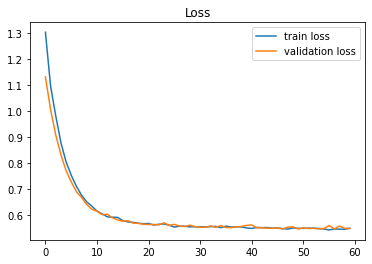

 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:30<00:35, 11.96s/it]

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 32)           2016        input_10[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 32)           0           dense_46[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 32)           1056        dropout_19[0][0]                 
___________________________________________________________________________________________

Epoch 33/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5565 - acc: 0.7257 - auc_9: 0.7612 - val_loss: 0.5602 - val_acc: 0.7486 - val_auc_9: 0.7614
Epoch 34/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5609 - acc: 0.7280 - auc_9: 0.7616 - val_loss: 0.5555 - val_acc: 0.7314 - val_auc_9: 0.7618
Epoch 35/100
3500/3500 [==============================] - 0s 38us/step - loss: 0.5547 - acc: 0.7369 - auc_9: 0.7620 - val_loss: 0.5533 - val_acc: 0.7400 - val_auc_9: 0.7623
Epoch 36/100
3500/3500 [==============================] - 0s 36us/step - loss: 0.5552 - acc: 0.7223 - auc_9: 0.7625 - val_loss: 0.5580 - val_acc: 0.7257 - val_auc_9: 0.7627
Epoch 37/100
3500/3500 [==============================] - 0s 36us/step - loss: 0.5559 - acc: 0.7294 - auc_9: 0.7628 - val_loss: 0.5526 - val_acc: 0.7357 - val_auc_9: 0.7631
Epoch 38/100
3500/3500 [==============================] - 0s 35us/step - loss: 0.5529 - acc: 0.7354 - auc_9: 0.7634 - val_loss: 0.5606 

3500/3500 [==============================] - 0s 32us/step - loss: 0.5450 - acc: 0.7311 - auc_9: 0.7725 - val_loss: 0.5457 - val_acc: 0.7171 - val_auc_9: 0.7725
Epoch 81/100
3500/3500 [==============================] - 0s 38us/step - loss: 0.5432 - acc: 0.7297 - auc_9: 0.7726 - val_loss: 0.5420 - val_acc: 0.7343 - val_auc_9: 0.7727
Epoch 82/100
3500/3500 [==============================] - 0s 37us/step - loss: 0.5453 - acc: 0.7294 - auc_9: 0.7727 - val_loss: 0.5386 - val_acc: 0.7300 - val_auc_9: 0.7728
Epoch 83/100
3500/3500 [==============================] - 0s 36us/step - loss: 0.5435 - acc: 0.7317 - auc_9: 0.7729 - val_loss: 0.5426 - val_acc: 0.7243 - val_auc_9: 0.7730
Epoch 84/100
3500/3500 [==============================] - 0s 34us/step - loss: 0.5452 - acc: 0.7309 - auc_9: 0.7730 - val_loss: 0.5370 - val_acc: 0.7371 - val_auc_9: 0.7731
Epoch 85/100
3500/3500 [==============================] - 0s 34us/step - loss: 0.5432 - acc: 0.7343 - auc_9: 0.7732 - val_loss: 0.5477 - val_acc: 0.

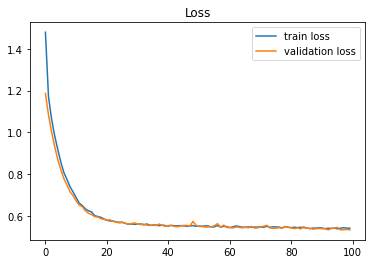

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:46<00:26, 13.18s/it]

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 32)           2016        input_11[0][0]                   
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 32)           0           dense_51[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 32)           1056        dropout_21[0][0]                 
___________________________________________________________________________________________

3500/3500 [==============================] - 0s 32us/step - loss: 0.5588 - acc: 0.7203 - auc_10: 0.7592 - val_loss: 0.5635 - val_acc: 0.7329 - val_auc_10: 0.7594
Epoch 33/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5562 - acc: 0.7283 - auc_10: 0.7596 - val_loss: 0.5607 - val_acc: 0.7343 - val_auc_10: 0.7600
Epoch 34/100
3500/3500 [==============================] - 0s 33us/step - loss: 0.5519 - acc: 0.7266 - auc_10: 0.7603 - val_loss: 0.5703 - val_acc: 0.7186 - val_auc_10: 0.7606
Epoch 35/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5586 - acc: 0.7223 - auc_10: 0.7608 - val_loss: 0.5601 - val_acc: 0.7386 - val_auc_10: 0.7610
Epoch 36/100
3500/3500 [==============================] - 0s 35us/step - loss: 0.5544 - acc: 0.7294 - auc_10: 0.7613 - val_loss: 0.5627 - val_acc: 0.7286 - val_auc_10: 0.7615
Epoch 37/100
3500/3500 [==============================] - 0s 34us/step - loss: 0.5574 - acc: 0.7251 - auc_10: 0.7617 - val_loss: 0.5606 - 

3500/3500 [==============================] - 0s 32us/step - loss: 0.5489 - acc: 0.7274 - auc_10: 0.7711 - val_loss: 0.5537 - val_acc: 0.7200 - val_auc_10: 0.7712
Epoch 79/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5492 - acc: 0.7257 - auc_10: 0.7713 - val_loss: 0.5678 - val_acc: 0.7214 - val_auc_10: 0.7713
Epoch 80/100
3500/3500 [==============================] - 0s 35us/step - loss: 0.5457 - acc: 0.7323 - auc_10: 0.7713 - val_loss: 0.5571 - val_acc: 0.7214 - val_auc_10: 0.7714
Epoch 81/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5472 - acc: 0.7226 - auc_10: 0.7715 - val_loss: 0.5513 - val_acc: 0.7186 - val_auc_10: 0.7715
Epoch 82/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5438 - acc: 0.7343 - auc_10: 0.7716 - val_loss: 0.5519 - val_acc: 0.7271 - val_auc_10: 0.7717
Epoch 83/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5437 - acc: 0.7323 - auc_10: 0.7718 - val_loss: 0.5531 - 

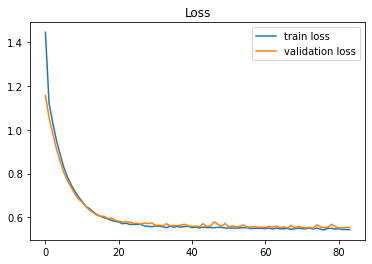

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:00<00:13, 13.47s/it]

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 32)           2016        input_12[0][0]                   
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 32)           0           dense_56[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 32)           1056        dropout_23[0][0]                 
___________________________________________________________________________________________

3500/3500 [==============================] - 0s 30us/step - loss: 0.5562 - acc: 0.7269 - auc_11: 0.7630 - val_loss: 0.5623 - val_acc: 0.7314 - val_auc_11: 0.7630
Epoch 33/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5572 - acc: 0.7274 - auc_11: 0.7632 - val_loss: 0.5584 - val_acc: 0.7271 - val_auc_11: 0.7635
Epoch 34/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5536 - acc: 0.7283 - auc_11: 0.7638 - val_loss: 0.5573 - val_acc: 0.7214 - val_auc_11: 0.7640
Epoch 35/100
3500/3500 [==============================] - 0s 31us/step - loss: 0.5519 - acc: 0.7314 - auc_11: 0.7644 - val_loss: 0.5654 - val_acc: 0.7086 - val_auc_11: 0.7645
Epoch 36/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5548 - acc: 0.7306 - auc_11: 0.7646 - val_loss: 0.5679 - val_acc: 0.7214 - val_auc_11: 0.7649
Epoch 37/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5539 - acc: 0.7323 - auc_11: 0.7651 - val_loss: 0.5555 - 

Epoch 79/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5443 - acc: 0.7331 - auc_11: 0.7738 - val_loss: 0.5418 - val_acc: 0.7343 - val_auc_11: 0.7739
Epoch 80/100
3500/3500 [==============================] - 0s 30us/step - loss: 0.5447 - acc: 0.7297 - auc_11: 0.7740 - val_loss: 0.5416 - val_acc: 0.7386 - val_auc_11: 0.7741
Epoch 81/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5430 - acc: 0.7289 - auc_11: 0.7742 - val_loss: 0.5415 - val_acc: 0.7371 - val_auc_11: 0.7742
Epoch 82/100
3500/3500 [==============================] - 0s 32us/step - loss: 0.5419 - acc: 0.7360 - auc_11: 0.7743 - val_loss: 0.5386 - val_acc: 0.7443 - val_auc_11: 0.7744
Epoch 83/100
3500/3500 [==============================] - 0s 27us/step - loss: 0.5491 - acc: 0.7269 - auc_11: 0.7744 - val_loss: 0.5486 - val_acc: 0.7300 - val_auc_11: 0.7745
Epoch 84/100
3500/3500 [==============================] - 0s 28us/step - loss: 0.5433 - acc: 0.7314 - auc_11: 0.7745 - val_lo

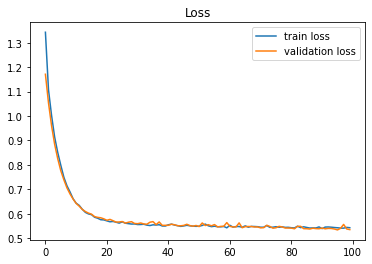

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.65s/it]


In [15]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
        
    # Define the Model architecture
    in_dnn = Input(shape=(X_train.shape[1],)) 
    x = Dense(32, activation='elu', input_shape=(max_features,), kernel_regularizer=l2(0.01), kernel_initializer='he_normal')(in_dnn) 
    x = Dropout(0.15)(x)
    x1 = Dense(32)(x)
    x = Add()([x1, x])
    x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x1 = Dense(16)(x)
    x = Add()([x1, x])
    out_dnn = Dense(1, activation='sigmoid')(x)

    model = Model(in_dnn, out_dnn)
    model.summary()

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.AUC()])

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=10),
                 keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                 monitor='val_loss',
                                                 save_best_only=True)]
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=callbacks)

    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())     
    
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

In [16]:
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))


Validation Summary:
2    0.806794
1    0.804184
9    0.801857
5    0.800515
7    0.799648
0    0.795492
4    0.794280
8    0.789701
3    0.788646
6    0.768392
dtype: float64
mean=0.79495, std=0.011


In [22]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Submission

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Submission


In [24]:
from scipy.stats.mstats import gmean
# Power mean ensemble
THRESHOLD = 0.8  # Use only models whose AUC exceeds this value

target_pred = []
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        target_pred.append(preds[i])
        n += 1
pred = gmean(target_pred)

# Make a submission file
t = pd.Timestamp.now()
fname = f"DNN_F1_En{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'DNN_F1_En4_submit_06151434.csv' is ready to submit.
